In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF, Linear

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import pickle

import high_dim_power as hd
import analytical as hd_ana

import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "cm"

In [3]:
tf.random.set_seed(1)

DELTA = 2.

BANDWIDTH_POWER = 1.

STATISTIC = "mmd" # "ksd" # 

KERNEL = RBF # Linear

DIR = "../res/high_dim"
SUFFIX = f"delta{DELTA}_r{BANDWIDTH_POWER}_{STATISTIC}_{KERNEL.__name__}"
EXTRA = ""

# Load results

In [4]:
# # load analytical res
# res_analytical_save = pd.read_csv(
#     f"{DIR}/res_analytical_{SUFFIX}.csv",
# )
# res_analytical = res_analytical_save.set_index("dim", drop=False)
# dims = res_analytical.dim.unique().tolist()

In [101]:
# dims = [1, 2, 4, 25, 50, 75, 100] #, 250, 500, 1000, 2000]
dims = [1, 2, 4, 25, 50, 75, 100, 250, 500, 1000, 2000]

In [103]:
# compute analytical res
NPOP = 6000 # 10000 # 4000

res_analytical = hd.compute_population_quantities(
    dims=dims, 
    bandwidth_order=BANDWIDTH_POWER, 
    kernel_class=KERNEL,
    npop=NPOP,
    delta=DELTA,
    statistic=STATISTIC,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:47<00:00,  4.30s/it]


In [104]:
res_analytical_dict = res_analytical
res_analytical = pd.DataFrame(res_analytical)
res_analytical["dim"] = dims
res_analytical.set_index("dim", drop=False, inplace=True)

# Compute analytical forms/bounds

In [105]:
def compute_analytical(stat_ana_class, dims, delta, bandwidth_power):
    res = {
        "dim": dims,
        "mean": [],
#         "m2": [],
#         "M2": [],
        "cond_var": [],
        "full_var": [],
        "m3_ub": [],
        "M3_ub": [],
    }

    for d in dims:
        if stat_ana_class == hd_ana.MMDLinearAnalytical:
            mu = np.eye(d)[:, 1] * delta

            sigma_mat = np.eye(d, dtype=np.float32) * 0.5
            sigma_mat[0, 0] = 0.5 * d
            
            stat_ana = stat_ana_class(
                dim=d,
                mu=mu,
                Sigma=sigma_mat,
                bandwidth_power=bandwidth_power,
            )
            
        else:
            stat_ana = stat_ana_class(
                dim=d,
                mu_norm=delta,
                bandwidth_power=bandwidth_power,
            )

        res["mean"].append(stat_ana.mean())
#         res["m2"].append(stat_ana.m2())
#         res["M2"].append(stat_ana.M2())
        res["cond_var"].append(stat_ana.cond_var())
        res["full_var"].append(stat_ana.full_var())
        res["m3_ub"].append(stat_ana.abs_cond_moment_ub(nu=3))
        res["M3_ub"].append(stat_ana.abs_full_moment_ub(nu=3))

    res_df = pd.DataFrame(res)
    return res_df
    

In [106]:
mmd_ana = compute_analytical(
    stat_ana_class=hd_ana.MMDAnalytical, 
    dims=dims, 
    delta=DELTA, 
    bandwidth_power=BANDWIDTH_POWER,
)

# Moments vs. dim

In [107]:
def plot(res_sim, res_expression):
    dims = res_expression["dim"].to_numpy()
    
    figs, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    axes[0].plot(dims, res_sim.loc[dims, "expectation"], marker="o", label="Truth")
    axes[0].plot(dims, res_expression["mean"], marker="x", label="Derived")
    axes[0].set_xlabel("Dim", fontsize=15)
    axes[0].set_ylabel("Mean", fontsize=15)
    axes[0].tick_params(labelsize=15)
    axes[0].legend(fontsize=11)
    axes[0].set_xscale("log")
    
    axes[1].plot(dims, res_sim.loc[dims, "cond_var"], marker="o", label="Truth")
    axes[1].plot(dims, res_expression["cond_var"], marker="x", label="Derived")
    axes[1].set_xlabel("Dim", fontsize=15)
    axes[1].set_ylabel(r"$\sigma_{\mathrm{cond}}^2$", fontsize=22)
    axes[1].tick_params(labelsize=15)
    axes[1].legend(fontsize=11)
    axes[1].set_xscale("log")

    axes[2].plot(dims, res_sim.loc[dims, "full_var"], marker="o", label="Truth")
    axes[2].plot(dims, res_expression["full_var"], marker="x", label="Derived")
    axes[2].set_xlabel("Dim", fontsize=15)
    axes[2].set_ylabel(r"$\sigma_{\mathrm{full}}^2$", fontsize=22)
    axes[2].tick_params(labelsize=15)
    axes[2].legend(fontsize=11)
    axes[2].set_xscale("log")

#     axes[3].plot(dims, res_sim.loc[dims, "m3"], marker="o", label="Truth")
#     axes[3].plot(dims, res_expression["m3_ub"], marker="x", label="Derived UB")
#     axes[3].set_xlabel("Dim", fontsize=15)
#     axes[3].set_ylabel(r"$M_{\mathrm{cond};3}^3$", fontsize=22)
#     axes[3].tick_params(labelsize=15)
#     axes[3].legend(fontsize=11)
    
    plt.tight_layout()
    
#     plt.savefig(f"../figs/high_dim/moments_{STATISTIC}_{KERNEL.__name__}.pdf", bbox_inches="tight")

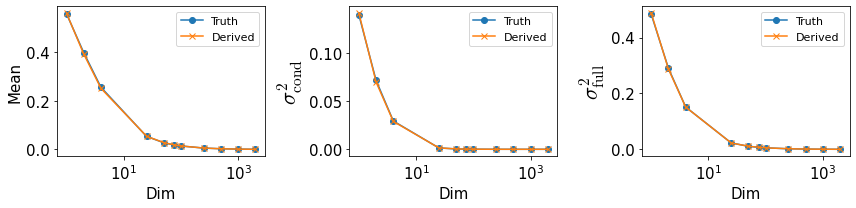

In [108]:
plot(res_analytical, mmd_ana)

# RBF-KSD

In [ ]:
# # load analytical res
# res_analytical_save = pd.read_csv(
#     f"{DIR}/res_analytical_verify_ksd_RBF.csv",
# )
# res_analytical = res_analytical_save.set_index("dim", drop=False)
# dims = res_analytical.dim.unique().tolist()

## Analytical

In [90]:
dims_ksd = [1, 2, 4, 25, 50, 75, 100, 250, 500, 1000, 2000]
NPOP_ksd = 4000

In [92]:
res_analytical_ksd = hd.compute_population_quantities(
    dims=dims_ksd, 
    bandwidth_order=BANDWIDTH_POWER, 
    kernel_class=KERNEL,
    npop=NPOP_ksd,
    delta=DELTA,
    statistic="ksd",
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [08:03<00:00, 43.97s/it]


In [93]:
res_analytical_dict_ksd = res_analytical_ksd
res_analytical_ksd = pd.DataFrame(res_analytical_ksd)
res_analytical_ksd["dim"] = dims
res_analytical_ksd.set_index("dim", drop=False, inplace=True)

## Derived

In [94]:
ksd_ana = compute_analytical(
    stat_ana_class=hd_ana.KSDAnalytical, 
    dims=dims,
    delta=DELTA, 
    bandwidth_power=BANDWIDTH_POWER,
)

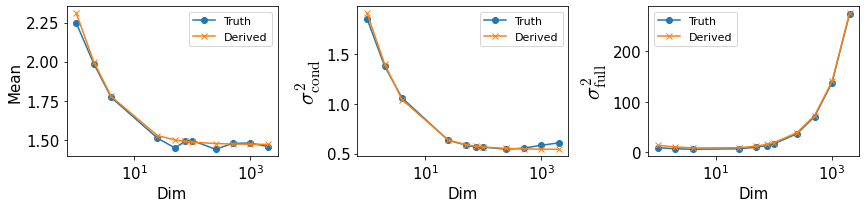

In [100]:
plot(res_analytical_ksd, ksd_ana)

# Linear-MMD

## Analytical

In [109]:
dims_lin = dims[1:]

In [110]:
res_analytical_lin = hd.compute_population_quantities(
    dims=dims_lin, 
    bandwidth_order=BANDWIDTH_POWER, 
    kernel_class=Linear,
    npop=int(1e5),
    delta=DELTA,
    statistic="mmd",
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [36:48<00:00, 220.86s/it]


In [111]:
res_analytical_dict_lin = res_analytical_lin
res_analytical_lin = pd.DataFrame(res_analytical_lin)
res_analytical_lin["dim"] = dims_lin
res_analytical_lin.set_index("dim", drop=False, inplace=True)

## Derived

In [112]:
lin_ana = compute_analytical(
    stat_ana_class=hd_ana.MMDLinearAnalytical, 
    dims=dims_lin,
    delta=DELTA, 
    bandwidth_power=BANDWIDTH_POWER,
)

TypeError: __init__() got an unexpected keyword argument 'bandwidth_power'

In [ ]:
plot(res_analytical_lin, lin_ana)